In [74]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler


In [75]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

In [76]:
def apply_z_score_normalization_except_profile_id(df):
    # Separate the column 'profile_id'
    profile_id = df['profile_id']
    
    # Select all columns except 'profile_id' for scaling
    df_to_scale = df.drop('profile_id', axis=1)

    # Creating a StandardScaler object
    scaler = StandardScaler()

    # Fitting the scaler to the data and transforming it
    df_scaled = scaler.fit_transform(df_to_scale)

    # Creating a new DataFrame with the scaled data
    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    # Adding the 'profile_id' column back to the scaled DataFrame
    df_scaled['profile_id'] = profile_id

    return df_scaled

# Usage Example
df_normalized = apply_z_score_normalization_except_profile_id(df)
df_normalized.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-1.238979,-0.799812,-1.648158,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,-2.443386,-0.400838,17
1,-1.236150,-0.799197,-1.647959,0.393521,-1.681047,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,-2.443396,-0.400082,17
2,-1.238757,-0.798729,-1.648064,0.392464,-1.681078,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,-2.443404,-0.400974,17
3,-1.236180,-0.798417,-1.648285,0.393356,-1.681146,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,-2.443409,-0.400174,17
4,-1.239442,-0.797432,-1.648303,0.393101,-1.681195,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,-2.443413,-0.400565,17


In [77]:
print(df_normalized.describe())

df = df_normalized

                u_q       coolant  stator_winding           u_d  stator_tooth  \
count  1.330816e+06  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06   
mean   7.553403e-16  3.970620e-16   -1.998871e-15 -7.756718e-17  1.236804e-15   
std    1.000000e+00  1.000000e+00    1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.801316e+00 -1.175346e+00   -1.665627e+00 -1.686374e+00 -1.688055e+00   
25%   -9.555356e-01 -8.047253e-01   -8.215244e-01 -8.488737e-01 -8.043913e-01   
50%   -1.209064e-01 -4.282472e-01   -4.299018e-02  2.806072e-01 -3.669520e-02   
75%    8.094359e-01  6.255120e-01    7.602662e-01  4.216716e-01  8.150887e-01   
max    1.782935e+00  3.000463e+00    2.616490e+00  2.482149e+00  2.399238e+00   

        motor_speed           i_d           i_q            pm   stator_yoke  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   4.073131e-16 -1.332652e-16 -3.803184e-16 -7.334712e-16 -6.078944e-16   
std    1.000000e+00  1.000000e+00

In [78]:
#no missing values
print(df.shape)
df.info()

(1330816, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [79]:
#function to trim sessions to an appropriate size
def preprocess(df, sessions_id, seq_len):
    target="torque"
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]

        #because the sequences based on the profile_id are not all the same lenghts, it takes the longest number of 
        #timestamps that is divisible for the seq_len that will be passed to our model

        #for each sequences we will lost a little bit of the dataset ( no more than the sequence_length = 100)
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

In [80]:
#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(h_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [81]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

sessions = preprocess(df, ids, seq_len)
print(sessions)

#create an lstm instance
model = NET(11, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

[(tensor([[-1.2486, -0.8570, -1.6638,  ..., -1.8708, -1.5000, -0.4760],
        [-1.2484, -0.8556, -1.6635,  ..., -1.8711, -1.4996, -0.4949],
        [-1.2525, -0.8552, -1.6632,  ..., -1.8713, -1.4990, -0.5063],
        ...,
        [-0.6708, -0.8276, -1.6207,  ..., -1.4575, -1.4184,  0.5414],
        [-0.6707, -0.8271, -1.6210,  ..., -1.4566, -1.4185,  0.5382],
        [-0.6707, -0.8261, -1.6200,  ..., -1.4558, -1.4184,  0.5264]]), tensor([-0.3976, -0.3965, -0.3968,  ..., -0.4037, -0.4036, -0.4036])), (tensor([[-1.1846, -0.8728, -1.6475,  ..., -1.7971, -1.4995, -0.7113],
        [-1.1824, -0.8721, -1.6480,  ..., -1.7973, -1.4988, -0.6990],
        [-1.1808, -0.8717, -1.6485,  ..., -1.7973, -1.4991, -0.6906],
        ...,
        [-0.6623, -0.8101, -1.3390,  ..., -0.5306, -1.2458,  0.6892],
        [-0.6623, -0.8093, -1.3388,  ..., -0.5303, -1.2458,  0.6665],
        [-0.6623, -0.8083, -1.3392,  ..., -0.5300, -1.2453,  0.6398]]), tensor([0.1345, 0.1557, 0.1699,  ..., 0.2664, 0.2665, 0.

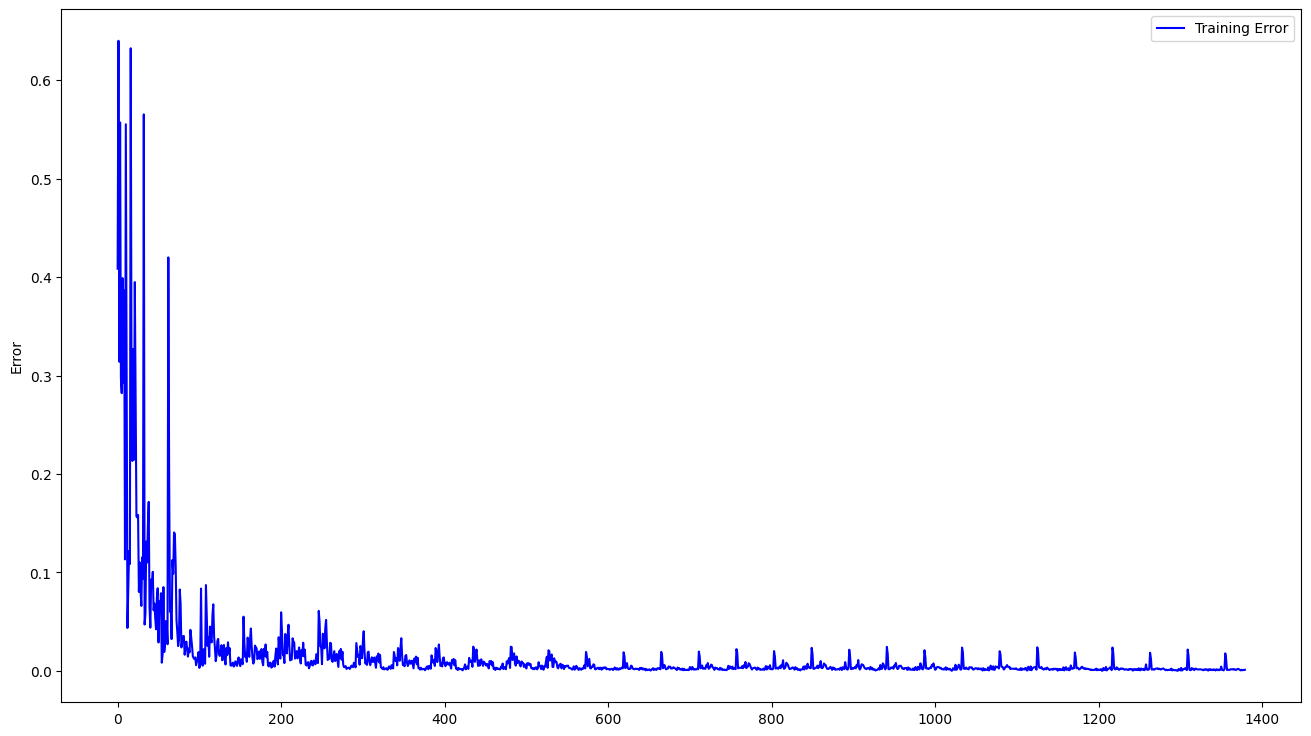

In [82]:
n_epochs = 30

#train model
train_losses = []

model.train()
for e in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, 11))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

Loss: 0.0011438421


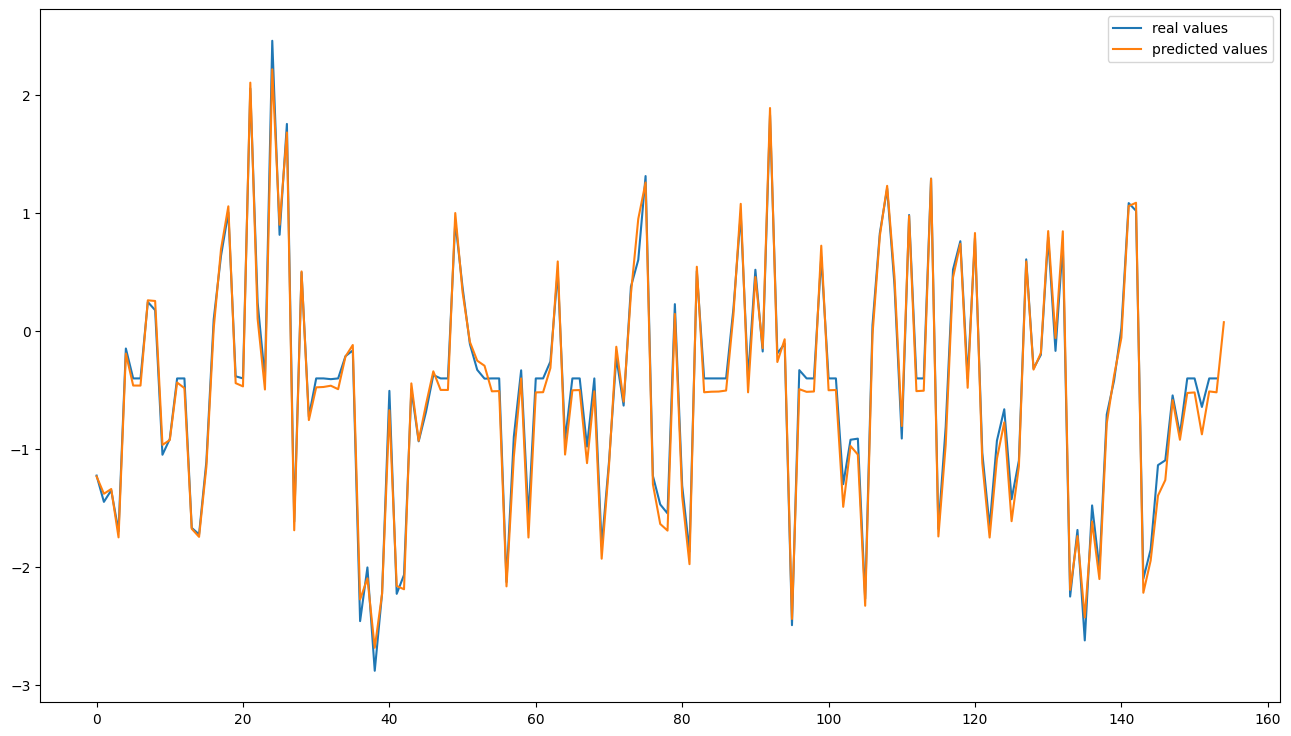

In [83]:
model.eval()

#evaluation on session 80 and 81
session_80 = df[df["profile_id"] == 80]
session_80 = session_80.iloc[:15500]

y = session_80["torque"]
X = session_80.drop(["torque", "profile_id"], axis=1)

X_80 = torch.from_numpy(X.values[:22000, :]).float() 
y_80 = torch.from_numpy(y.values[:22000]).float()

out = model.forward(X_80.view(-1, seq_len, 11))
loss = criterion(out, y_80.view(-1, seq_len, 1))
print("Loss: " + str(loss.detach().numpy()))

out = out[:, -1, :]
pred = out.detach().numpy().flatten()
real = y_80.numpy()[seq_len::seq_len]

plt.plot(real.flatten(), label="real values")
plt.plot(pred, label="predicted values")
plt.legend(loc='upper right')
plt.show()